In [185]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import sgml, sgutil

# Preparation

In [143]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org_train', data_path, 'train_org.csv'),
        ('org_test', data_path, 'test_org.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
sc = sgutil.SGCache('img', 'result')

In [144]:
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_var = pd.read_pickle(files['var_pkl'])
df_var.drop(index=['id', 'Response'], inplace=True)

In [145]:
df_var

,n_unique,src,Description,type
Age,66.00,org,,Int8
Annual_Premium,46734.25,org,,Float32
Driving_License,2.00,org,,Int8
Gender,2.00,org,,Categorical
Policy_Sales_Channel,150.75,org,,Categorical
Previously_Insured,2.00,org,,Int8
Region_Code,53.25,org,,Categorical
Vehicle_Age,3.00,org,,Categorical
Vehicle_Damage,2.00,org,,Categorical
Vintage,290.00,org,,Int16


In [148]:
target = 'Response'
X_cat = df_var.loc[df_var['type'] == 'Categorical'].index.tolist()
X_bool = df_var.loc[(df_var['n_unique'] == 2) & (~df_var['type'].isin(X_cat))].index.tolist() + ['is_Annual_Premium_mode']
X_num = df_var.loc[~df_var.index.isin(X_cat + X_bool)].index.tolist()
X_all = df_test.columns.tolist()
print(np.array(X_cat))
print(np.array(X_bool))
print(np.array(X_num))

['Gender' 'Policy_Sales_Channel' 'Region_Code' 'Vehicle_Age'
 'Vehicle_Damage']
['Driving_License' 'Gender' 'Previously_Insured' 'Vehicle_Damage'
 'is_Annual_Premium_mode']
['Age' 'Annual_Premium' 'Vintage' 'log_Annual_Premium']


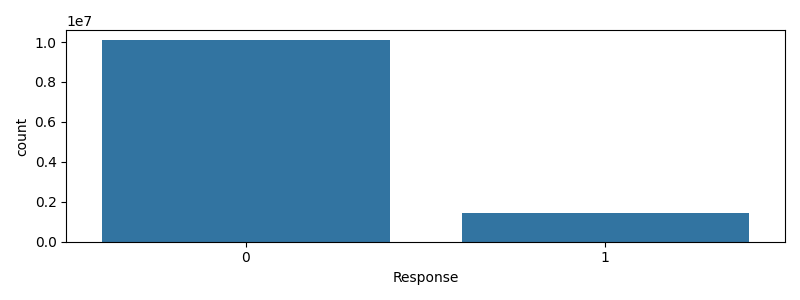

In [168]:
sc.cache_fig(
    'freq_target',
    lambda x: sns.barplot(df_train[target].value_counts(), ax=x), figsize=(8, 3)
)

# Categorical Variables 

In [149]:
from scipy.stats import chi2_contingency

for i in X_cat + X_bool:
    df_conti = sc.cache_result('conti_{}'.format(i),
        lambda : df_train.pivot_table(index=i, columns=target, observed=True, aggfunc='size').fillna(0)
    )
    print(i, chi2_contingency(df_conti).pvalue)
    display(df_conti.pipe(lambda x: x.div(x.sum(axis=1), axis=0)).join(df_train[i].value_counts().rename('count')).sort_values('count', ascending=False))

Gender 0.0


,0,1,count
Gender,,,
Male,0.860312,0.139688,6228134
Female,0.896703,0.103297,5276664


Policy_Sales_Channel 0.0


,0,1,count
Policy_Sales_Channel,,,
152.0,0.973778,0.026222,4166183
26.0,0.792237,0.207763,2433456
124.0,0.807504,0.192496,2264490
160.0,0.979304,0.020696,640380
156.0,0.795073,0.204927,316693
...,...,...,...
102.0,1.000000,0.000000,4
112.0,1.000000,0.000000,3
27.0,1.000000,0.000000,2


Region_Code 0.0


,0,1,count
Region_Code,,,
28.0,0.808189,0.191811,3451062
8.0,0.912282,0.087718,1021036
46.0,0.903837,0.096163,578208
41.0,0.885869,0.114131,557581
15.0,0.932565,0.067435,403977
30.0,0.930500,0.069500,367307
29.0,0.883252,0.116748,338146
50.0,0.936021,0.063979,302334
11.0,0.892213,0.107787,278261


Vehicle_Age 0.0


,0,1,count
Vehicle_Age,,,
1-2 Year,0.822275,0.177725,5982678
< 1 Year,0.958596,0.041404,5044145
> 2 Years,0.700951,0.299049,477975


Vehicle_Damage 0.0


,0,1,count
Vehicle_Damage,,,
Yes,0.759470,0.240530,5783229
No,0.995802,0.004198,5721569


Driving_License 1.7058045796900096e-213


,0,1,count
Driving_License,,,
1,0.876868,0.123132,11482041
0,0.944852,0.055148,22757


Gender 0.0


,0,1,count
Gender,,,
Male,0.860312,0.139688,6228134
Female,0.896703,0.103297,5276664


Previously_Insured 0.0


,0,1,count
Previously_Insured,,,
0,0.771507,0.228493,6178116
1,0.999362,0.000638,5326682


Vehicle_Damage 0.0


,0,1,count
Vehicle_Damage,,,
Yes,0.759470,0.240530,5783229
No,0.995802,0.004198,5721569


is_Annual_Premium_mode 3.062042722574812e-129


,0,1,count
is_Annual_Premium_mode,,,
0,0.878113,0.121887,9392237
1,0.872064,0.127936,2112561


## Policy_Sales_Channel

In [150]:
df_conti = sc.cache_result('conti_Policy_Sales_Channel'.format(i),
    lambda : df_train.pivot_table(index='Policy_Sales_Channel', columns=target, observed=True, aggfunc='size').fillna(0)
)

In [151]:
pd.concat([
    df_conti, 
    df_train['Policy_Sales_Channel'].value_counts().rename('train_count'),
    df_test['Policy_Sales_Channel'].value_counts().rename('test_count')
], axis=1).sort_values('train_count').iloc[:30]

,0,1,train_count,test_count
Policy_Sales_Channel,,,,
5.0,1.0,0.0,1.0,NaN
6.0,1.0,0.0,1.0,NaN
27.0,2.0,0.0,2.0,5.0
112.0,3.0,0.0,3.0,4.0
102.0,4.0,0.0,4.0,5.0
33.0,4.0,1.0,5.0,NaN
2.0,3.0,3.0,6.0,1.0
34.0,6.0,1.0,7.0,3.0
105.0,7.0,0.0,7.0,5.0


In [152]:
# 5.0, 6.0, 33.0은 test에는 등장하지 않은 범주이므로 삭제를 해도 무방합니다.
df_train.loc[df_train['Policy_Sales_Channel'].isin(['5.0', '6.0', '33.0'])]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_Annual_Premium_mode,log_Annual_Premium
id,,,,,,,,,,,,,
202578,Female,62,1,50.0,1,1-2 Year,No,36628.0,33.0,97,0,0,10.508569
451535,Female,22,1,8.0,0,< 1 Year,Yes,39495.0,6.0,189,0,0,10.583930
844680,Female,53,1,28.0,0,1-2 Year,Yes,44302.0,33.0,76,0,0,10.698786
2674524,Female,46,1,28.0,0,> 2 Years,Yes,44302.0,33.0,56,0,0,10.698786
3613846,Male,46,1,28.0,0,1-2 Year,Yes,44302.0,33.0,76,1,0,10.698786
9854728,Male,36,1,28.0,0,> 2 Years,Yes,30203.0,5.0,109,0,0,10.315698
10981127,Male,38,1,14.0,1,1-2 Year,No,31458.0,33.0,33,0,0,10.356410


## Region_Code

In [153]:
df_conti = sc.cache_result('conti_Region_Code'.format(i),
    lambda : df_train.pivot_table(index='Region_Code', columns=target, observed=True, aggfunc='size').fillna(0)
)
pd.concat([
    df_conti, 
    df_train['Region_Code'].value_counts().rename('train_count'),
    df_test['Region_Code'].value_counts().rename('test_count')
], axis=1).sort_values('train_count').iloc[:30]

,0,1,train_count,test_count
Region_Code,,,,
39.2,1.0,0.0,1,NaN
51.0,1527.0,353.0,1880,1260.0
52.0,3055.0,395.0,3450,2295.0
42.0,12484.0,1209.0,13693,9042.0
44.0,19703.0,602.0,20305,13583.0
1.0,30499.0,3467.0,33966,22359.0
40.0,31516.0,4372.0,35888,23831.0
5.0,32687.0,4145.0,36832,24220.0
22.0,34686.0,2246.0,36932,24443.0


In [154]:
# 39.2는 test에는 등장하지 않은 범주이므로 삭제를 해도 무방합니다.
df_train.loc[df_train['Region_Code'] == '39.2']

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_Annual_Premium_mode,log_Annual_Premium
id,,,,,,,,,,,,,
11370234,Female,20,1,39.2,1,< 1 Year,No,2630.0,159.0,74,0,1,10.511115


In [155]:
df_train.drop(
    index=df_train.loc[df_train['Policy_Sales_Channel'].isin(['5.0', '6.0', '33.0'])].index.tolist() + 
        df_train.loc[df_train['Region_Code'] == '39.2'].index.tolist(), inplace=True
)

## Numeric Variables

In [207]:
df_train.groupby('Age', observed=True)[target].mean()

Age
20    0.022438
21    0.031871
22    0.032953
23    0.033138
24    0.031142
        ...   
81    0.058824
82    0.011765
83    0.049383
84    0.000000
85    0.000000
Name: Response, Length: 66, dtype: float64

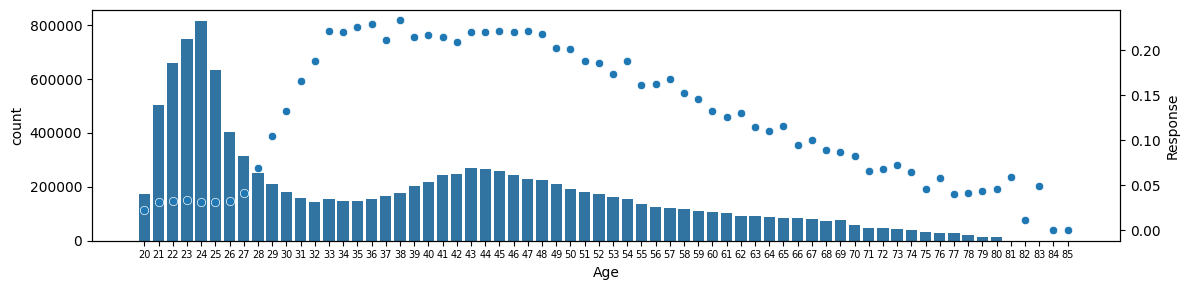

In [213]:
def bar_scatter_Age(ax):
    ax.tick_params(axis='x', labelsize=7)
    sns.barplot(df_train['Age'].value_counts().sort_index(), ax=ax)
    sns.scatterplot(df_train.groupby('Age', observed=True, as_index=False)[target].mean().assign(Age=lambda x: x['Age'] - x['Age'].min()), 
                    x='Age',  y=target, ax=ax.twinx())
sc.cache_fig(
    'hist_age', lambda x: bar_scatter_Age(x), figsize=(12, 3), redraw=True
)

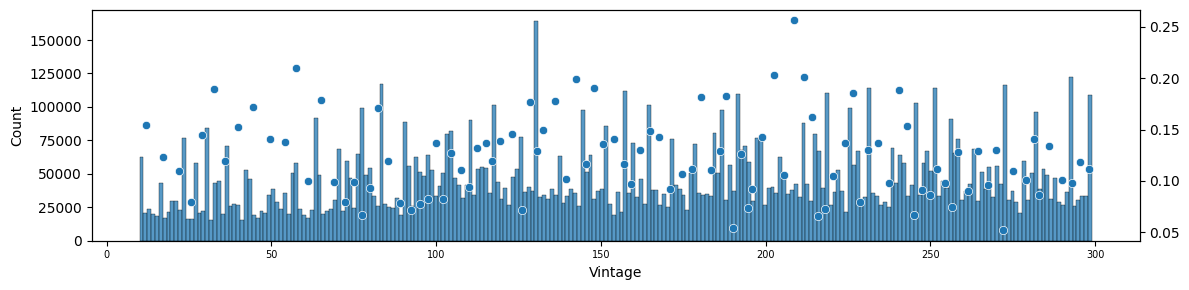

In [193]:
def hist_scatter_Vintage(ax):
    ax.tick_params(axis='x', labelsize=7)
    sns.histplot(df_train['Vintage'], ax=ax)
    df_train.groupby(pd.qcut(df_train['Vintage'], q=100, duplicates='drop'), observed=True)[target].mean()\
    .pipe(
        lambda x: sns.scatterplot(x=x.index.map(lambda x: (x.left + x.right) / 2),  y=x.values, ax=ax.twinx())
    )
sc.cache_fig(
    'hist_Vintage', lambda x: hist_scatter_Vintage(x), figsize=(12, 3)
)

In [202]:
from scipy.stats import mannwhitneyu
(
    mannwhitneyu(
        df_train.loc[df_train[target] == 0, 'Vintage'],
        df_train.loc[df_train[target] == 1, 'Vintage']
    ), df_train.loc[df_train[target] == 0, 'Vintage'].median()
    , df_train.loc[df_train[target] == 1, 'Vintage'].median()
)

(MannwhitneyuResult(statistic=7326585102147.0, pvalue=0.0), 167.0, 164.0)

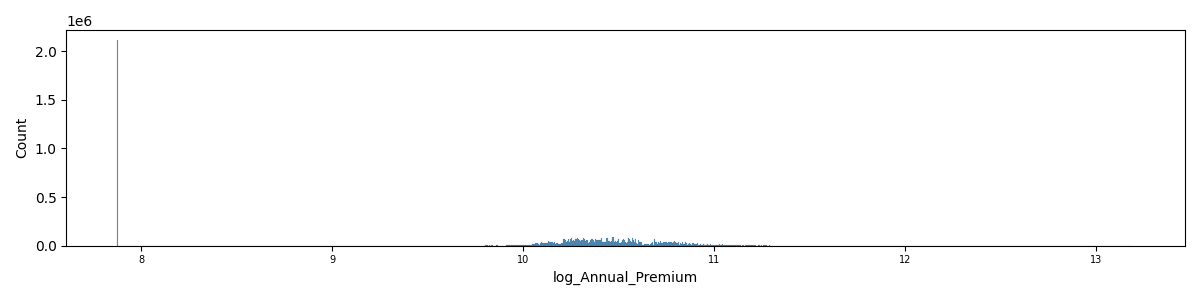

In [158]:
sc.cache_fig(
    'hist_Annual_Premium', lambda x: sns.histplot(np.log(df_train['Annual_Premium']).rename('log_Annual_Premium'), ax=x.tick_params(axis='x', labelsize=7)), 
    figsize=(12, 3)
)

In [159]:
df_train.loc[df_train['Annual_Premium'] < 5000, 'Annual_Premium'].value_counts()

Annual_Premium
2630.0    2112560
2730.0         10
2909.0          6
3972.0          5
4023.0          5
           ...   
4040.0          1
3419.0          1
4745.0          1
4260.0          1
4570.0          1
Name: count, Length: 202, dtype: int64

In [160]:
df_train['Annual_Premium'].describe()

count    1.150479e+07
mean     3.046137e+04
std      1.645475e+04
min      2.630000e+03
25%      2.527700e+04
50%      3.182400e+04
75%      3.945100e+04
max      5.401650e+05
Name: Annual_Premium, dtype: float64

2630이 가장 빈도수가 높고, 작은수 입니다.

Annual_Premium이 2630인 여부를 체크하는 변수를 만들고,

자연로그 변환 후에 2630인 경우를 제외하고 평균의 값으로 2630인 경우를 치환하는 변환을 만들어 모수적 모델에서 사용하게 합니다.

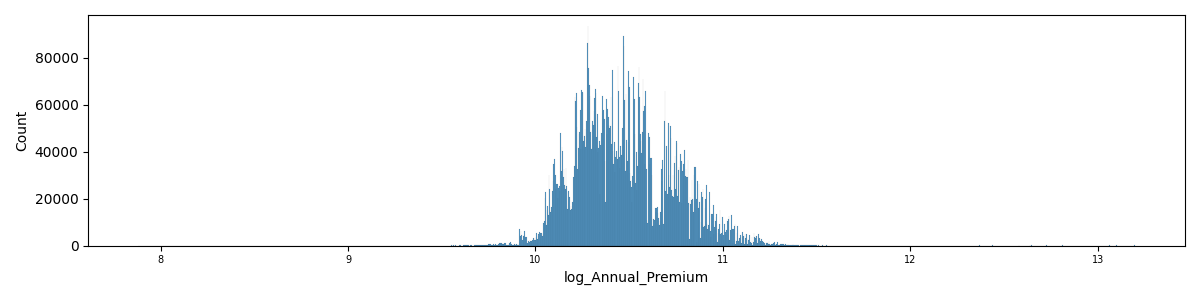

In [162]:

sc.cache_fig(
    'hist_Annual_Premium_2', lambda x: sns.histplot(df_train['log_Annual_Premium'], 
    ax=x.tick_params(axis='x', labelsize=7)), figsize=(12, 3)
)

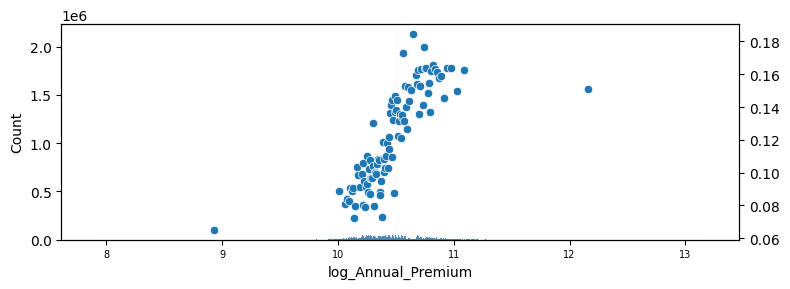

In [192]:
def hist_scatter_log_Annual_Premium_plot(ax):
    ax.tick_params(axis='x', labelsize=7)
    sns.histplot(df_train['log_Annual_Premium'], ax=ax)
    df_train.loc[df_train['is_Annual_Premium_mode'] == 0].pipe(
        lambda x: x.groupby(pd.qcut(x['log_Annual_Premium'], q=100, duplicates='drop'), observed=True)[target].mean()
    ).pipe(
        lambda x: sns.scatterplot(x=x.index.map(lambda x: (x.left + x.right) / 2),  y=x.values, ax=ax.twinx())
    )
sc.cache_fig('log_Annual_Premium_plot',
    lambda x: hist_scatter_log_Annual_Premium_plot(x)
)             

# Train/Test

In [164]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
roc_scores = sc.cache_result('is_train_test',
    lambda : pd.concat([
        df_train[X_all].assign(is_train=True),
        df_test[X_all].assign(is_train=False)
    ]).assign(
        Region_Code = lambda x: x['Region_Code'].astype('category'), 
        Policy_Sales_Channel = lambda x: x['Policy_Sales_Channel'].astype('category')
    ).pipe(
        lambda x: cross_val_score(
            lgb.LGBMClassifier(verbose=-1), x[X_all], x['is_train'], 
            cv=ShuffleSplit(1, random_state=123, train_size=0.8), scoring='roc_auc',
            params={'categorical_feature': X_cat}
        )
    )
)
roc_scores

array([0.49980859])

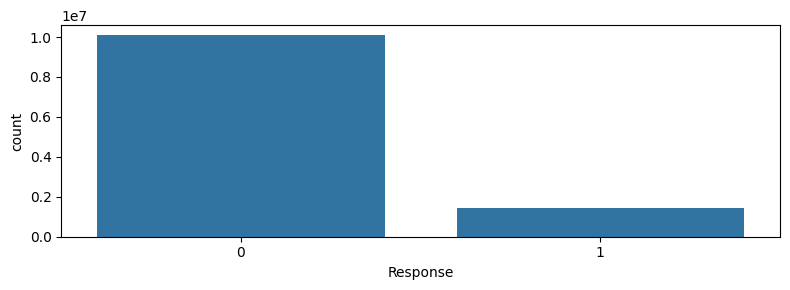